In [1]:
# additional functions to handle the data
from polepos_funcs import load_transmission_data_csv, plot_trcs, plot_search_results, delete_nan_cs_rows, search_peaks
import pandas as pd
import json

In [2]:
%matplotlib widget

In [3]:
# input data - transmission dataframe - syndat output and calculating the cross section values

tr_filename = 'test_data/_Emin_10_Emax_1000_2022.10.30_transmission_4980.csv'
n = 0.067166 # atoms per barn or atoms/(1e-12*cm^2)

transm_df = load_transmission_data_csv(tr_filename, n=n)
transm_df

Initial data file contains 7240 elements
Warning! There are  9  points in the data file with NAN elements


/home/fire/py_projects/ATARI_polepos/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,index,tof,E,theo_trans,exp_trans,exp_trans_unc,theo_cs,exp_cs
0,7239,0.000808,10.002042,0.787265,0.749716,0.087202,3.561178,4.288790
1,7238,0.000808,10.004530,0.787265,0.753300,0.089812,3.561175,4.217775
2,7237,0.000807,10.007018,0.787266,0.830353,0.086920,3.561173,2.767828
3,7236,0.000807,10.009507,0.787266,0.683137,0.072564,3.561170,5.673412
4,7235,0.000807,10.011998,0.787266,0.604820,0.069327,3.561167,7.486286
...,...,...,...,...,...,...,...,...
7235,4,0.000084,990.128685,0.789288,0.751434,0.030949,3.522966,4.254702
7236,3,0.000084,992.582765,0.802227,0.772513,0.031699,3.280889,3.842806
7237,2,0.000084,995.045981,0.712332,0.736246,0.030045,5.050351,4.558724
7238,1,0.000084,997.518377,0.765120,0.772038,0.031438,3.985976,3.851971


In [4]:
# deleting all points with the negative transmission
transm_nonzero = delete_nan_cs_rows(transm_df)

Count in initial: 7240 
Count in cleaned 7231


/home/fire/py_projects/ATARI_polepos/ATARI/PolePosition/polepos_funcs.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wo_NANS.drop(['index'], axis=1, inplace = True)


In [5]:
# loading ladder
ladder_filename = 'test_data/_Emin_10_Emax_1000_2022.10.30_ladder.csv'

ladder_df = pd.read_csv(ladder_filename, index_col=0)

#modifying the ladder using json for correct lists in data lwave
test = ladder_df.lwave.apply(json.loads)
ladder_df['lwave'] = test

ladder_df

,E,Gg,gnx2,J,chs,lwave,J_ID
0,40.293681,85.570035,2.529949,3.0,1,[0],1
1,55.462105,87.068916,181.330785,3.0,1,[0],1
2,66.197237,78.186040,102.663139,3.0,1,[0],1
3,81.226028,84.957739,6.687319,3.0,1,[0],1
4,101.050190,87.766401,26.585248,3.0,1,[0],1
5,140.793848,83.087167,49.680917,3.0,1,[0],1
6,157.220080,75.532152,17.394776,3.0,1,[0],1
7,171.433258,85.010630,13.587750,3.0,1,[0],1
8,217.165426,78.271798,6.263354,3.0,1,[0],1
9,221.410561,83.512046,6.959765,3.0,1,[0],1


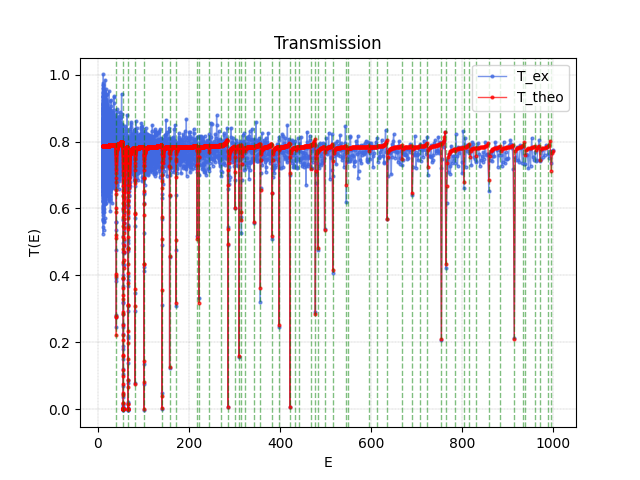

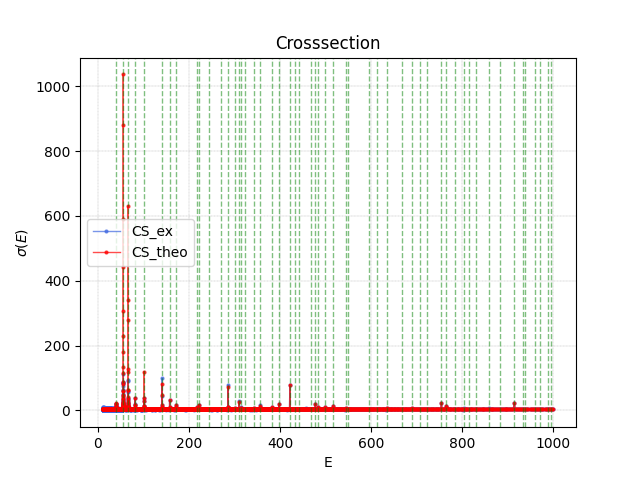

In [6]:
# plotting what we have
plot_trcs(
    [transm_df['E'].to_numpy(), transm_df['E'].to_numpy()],
    [transm_df['exp_trans'].to_numpy(), transm_df['theo_trans'].to_numpy()],
    'Transmission',
    ['T_ex', 'T_theo'],
    'E',
    'T(E)',
    ladder_df
)

# the same for cross-section values and adding the "clear values"
# plotting what we have
plot_trcs(
    [transm_df['E'].to_numpy(), transm_df['E'].to_numpy(), ],
    [transm_df['exp_cs'].to_numpy(), transm_df['theo_cs'].to_numpy()],
    'Crosssection',
    ['CS_ex', 'CS_theo', 'CS_ex_woNANS'],
    'E',
    '$\sigma(E)$',
    ladder_df
)

In [14]:
# using the find_all procedure to get all the peaks of cross-sections

pulses_sel_df, pulses_all_df  = search_peaks(transm_nonzero, 
                 search_params = {'part_of_variance_filter': 0.2,
                                  'base_of_peak': 0.5, 
                                 'min_width': 0.01,
                                 'min_height': 0.01,
                                 'prominence': 0.01
                                 }, 
                                 
                 reduce_params = {'param_cutoff_by_name': 'peak_sq_divE',
                                  #'param_cutoff_by_name': 'peak_sq',
                                  'cutoff_threshold': 0.03
                                }
)

Initial search gives: 1480 peaks
Selected 164 peaks from 1480


In [15]:
# actual number of resonances in a current ladder

print(f'We have in a actual ladder: {ladder_df.shape[0]}')

We have in a actual ladder: 53


In [16]:
# sorting result by weighted square
# pulses_sel_df.sort_values(by=['peak_sq_divE'], ascending=True)

In [17]:
# pulses_all_df.sort_values(by=['peak_height'], ascending=True)

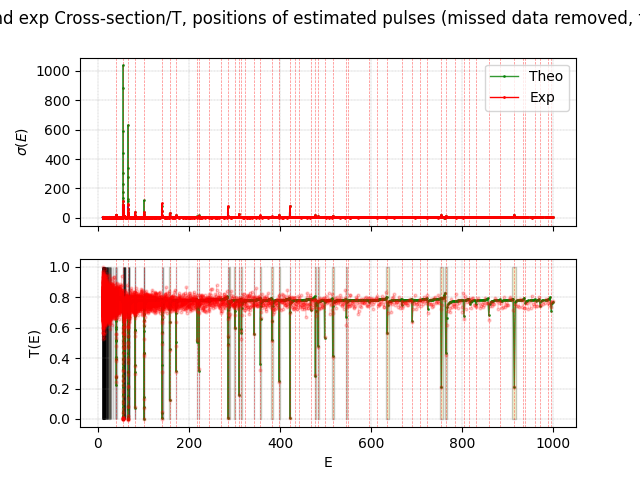

In [18]:
# plotting the results
plot_search_results(transm_df, ladder_df, pulses_sel_df)

In [12]:
pulses_sel_df

,idx_global_num,x,peak_E,peak_left_border_indx,peak_right_border_indx,peak_width_samples,peak_relative_prom_width_height,peak_left_border_E,peak_right_border_E,peak_width_E,peak_height,peak_prominence,peak_numpoints,peak_simple_sq,peak_sq,peak_sq_divE,selected
0,0,4,10.011998,2,6,4,5.138313,10.007018,10.016981,0.009963,7.295902,4.315179,5,0.072688,0.055143,5.534872,1.0
1,1,8,10.021968,7,9,2,3.748501,10.019474,10.024463,0.004989,4.076487,0.655972,3,0.020337,0.018253,3.658759,1.0
2,2,12,10.031953,11,13,2,5.231559,10.029456,10.034452,0.004996,6.416407,2.369696,3,0.032059,0.029099,5.823985,1.0
3,3,16,10.041953,15,18,3,4.947849,10.039452,10.046959,0.007507,8.045290,6.194883,4,0.060396,0.047711,6.355529,1.0
4,4,19,10.049463,18,20,2,6.098151,10.046959,10.051968,0.005010,6.521099,0.845896,3,0.032668,0.030871,6.162530,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,2260,7214,961.376111,7210,7216,6,3.868932,952.069794,966.080522,14.010728,4.409101,1.080337,7,61.774715,57.940639,4.135448,1.0
2261,2261,7218,970.819549,7217,7220,3,3.970458,968.445687,975.593532,7.147844,4.379936,0.818956,4,31.307100,29.551286,4.134293,1.0
2262,2262,7221,977.993739,7220,7223,3,3.990654,975.593532,982.820804,7.227272,4.162224,0.343139,4,30.081522,28.872729,3.994969,1.0
2263,2263,7226,990.128685,7225,7227,2,4.060890,987.683694,992.582765,4.899071,4.223859,0.325937,3,20.692987,20.328218,4.149402,1.0


In [13]:
pulses_all_df

,idx_global_num,x,peak_E,peak_left_border_indx,peak_right_border_indx,peak_width_samples,peak_relative_prom_width_height,peak_left_border_E,peak_right_border_E,peak_width_E,peak_height,peak_prominence,peak_numpoints,peak_simple_sq,peak_sq,peak_sq_divE,selected
0,0,4,10.011998,2,6,4,5.138313,10.007018,10.016981,0.009963,7.295902,4.315179,5,0.072688,0.055143,5.534872,1.0
1,1,8,10.021968,7,9,2,3.748501,10.019474,10.024463,0.004989,4.076487,0.655972,3,0.020337,0.018253,3.658759,1.0
2,2,12,10.031953,11,13,2,5.231559,10.029456,10.034452,0.004996,6.416407,2.369696,3,0.032059,0.029099,5.823985,1.0
3,3,16,10.041953,15,18,3,4.947849,10.039452,10.046959,0.007507,8.045290,6.194883,4,0.060396,0.047711,6.355529,1.0
4,4,19,10.049463,18,20,2,6.098151,10.046959,10.051968,0.005010,6.521099,0.845896,3,0.032668,0.030871,6.162530,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,2260,7214,961.376111,7210,7216,6,3.868932,952.069794,966.080522,14.010728,4.409101,1.080337,7,61.774715,57.940639,4.135448,1.0
2261,2261,7218,970.819549,7217,7220,3,3.970458,968.445687,975.593532,7.147844,4.379936,0.818956,4,31.307100,29.551286,4.134293,1.0
2262,2262,7221,977.993739,7220,7223,3,3.990654,975.593532,982.820804,7.227272,4.162224,0.343139,4,30.081522,28.872729,3.994969,1.0
2263,2263,7226,990.128685,7225,7227,2,4.060890,987.683694,992.582765,4.899071,4.223859,0.325937,3,20.692987,20.328218,4.149402,1.0
